<a href="https://colab.research.google.com/github/2403a52030-sketch/NLP-LAB/blob/main/NLP_LAB_12_2403a52030.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Numerical computations
import numpy as np

# Data handling
import pandas as pd

# PyTorch core libraries
import torch
import torch.nn as nn
import torch.optim as optim

# Dataset utilities
from torch.utils.data import Dataset, DataLoader

# Text preprocessing and evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Visualization (optional)
import matplotlib.pyplot as plt


In [4]:
# Load SMS Spam Collection dataset
data = pd.read_csv(
    "/content/SMSSpamCollection",
    sep="\t",
    header=None,
    names=["label", "message"]
)

# Display first rows
data.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [9]:
# Download GloVe (run once)
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip


--2026-02-19 04:19:33--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-02-19 04:19:33--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-02-19 04:19:33--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [16]:
class TextCNN(nn.Module):
    def __init__(self):
        super(TextCNN, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.embedding.weight = nn.Parameter(torch.tensor(embedding_matrix, dtype=torch.float32))
        self.embedding.weight.requires_grad = False  # pretrained embeddings only

        self.conv = nn.Conv1d(embedding_dim, 128, kernel_size=5)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool1d(2)
        self.fc = nn.Linear(128 * 23, 2)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0, 2, 1)
        x = self.pool(self.relu(self.conv(x)))
        x = x.view(x.size(0), -1)
        return self.fc(x)


In [34]:
print("Number of samples:", len(data)) # Prints the total number of rows (samples) in the DataFrame.
print("Class distribution:\n", data['label'].value_counts()) # Shows the count of each unique value in the 'label' column.

Number of samples: 5572
Class distribution:
 label
ham     4825
spam     747
Name: count, dtype: int64


In [35]:
import re # Imports the regular expression module for text manipulation.

def clean_text(text): # Defines a function to clean text.
    text = text.lower() # Converts all characters in the text to lowercase.
    text = re.sub(r"[^a-z\s]", "", text) # Removes any character that is not a lowercase letter or a space.
    return text # Returns the cleaned text.

data["cleaned"] = data["message"].apply(clean_text) # Applies the clean_text function to each message and stores the result in a new 'cleaned' column.

In [36]:
import nltk # Imports the Natural Language Toolkit library.
from nltk.tokenize import word_tokenize # Imports the word_tokenize function for breaking text into words.

nltk.download('punkt') # Downloads the 'punkt' tokenizer models if not already present.
nltk.download('punkt_tab') # Downloads the 'punkt_tab' tokenizer models, often used for sentence segmentation.

# Tokenize the cleaned text
data['tokens'] = data['cleaned'].apply(word_tokenize) # Applies word_tokenize to each cleaned message to create a list of words (tokens).

# Build vocabulary: Count word frequencies to build a vocabulary.
word_freq = {} # Initializes an empty dictionary to store word frequencies.
for tokens in data["tokens"]: # Iterates through each list of tokens in the 'tokens' column.
    for word in tokens: # Iterates through each word in the current list of tokens.
        word_freq[word] = word_freq.get(word, 0) + 1 # Increments the count for each word; initializes to 0 if new.

# Word to index mapping: Create a dictionary that maps each unique word to a unique integer index.
vocab = {word: idx + 2 for idx, word in enumerate(word_freq)} # Assigns indices starting from 2 to actual words.
vocab["<PAD>"] = 0 # Assigns index 0 to a special padding token.
vocab["<UNK>"] = 1 # Assigns index 1 to a special unknown word token.

vocab_size = len(vocab) # Stores the total number of unique words plus special tokens.
embedding_dim = 100 # Sets the desired dimension for word embeddings (e.g., GloVe 100d).

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
# Load GloVe vectors
embeddings_index = {} # Initializes an empty dictionary to store word-to-vector mappings.

with open("glove.6B.100d.txt", "r", encoding="utf-8") as f: # Opens the 100-dimensional GloVe file for reading.
    for line in f: # Iterates through each line in the GloVe file.
        values = line.split() # Splits the line into words and vector components.
        word = values[0] # The first element is the word.
        vector = np.asarray(values[1:], dtype="float32") # The rest are the vector components, converted to a NumPy array of floats.
        embeddings_index[word] = vector # Stores the word and its corresponding vector in the dictionary.

In [ ]:
# Create embedding matrix: Initialize a matrix with zeros that will store the embeddings for our vocabulary.
embedding_matrix = np.zeros((vocab_size, embedding_dim)) # Dimensions are (number of unique words, embedding dimension).

for word, idx in vocab.items(): # Iterate through each word and its assigned index in our custom vocabulary.
    vector = embeddings_index.get(word) # Try to retrieve the pre-trained GloVe vector for the current word.
    if vector is not None: # If a GloVe vector exists for the word...
        embedding_matrix[idx] = vector # ...assign it to the corresponding index in our embedding matrix.

In [ ]:
# Encode labels: Convert categorical labels ('ham', 'spam') into numerical values.
label_map = {"ham": 0, "spam": 1} # Define the mapping from text labels to integers.
data["label_encoded"] = data["label"].map(label_map) # Apply the mapping to the 'label' column to create a new 'label_encoded' column.

X_train, X_test, y_train, y_test = train_test_split(
    data["tokens"], # Input features: tokenized messages.
    data["label_encoded"], # Target labels: encoded ham/spam labels.
    test_size=0.2, # Allocate 20% of the data for the test set.
    random_state=42, # Set a seed for reproducibility of the split.
    stratify=data["label_encoded"] # Ensure that the proportion of 'ham' and 'spam' is the same in both train and test sets.
)

In [ ]:
max_len = 50 # Defines the maximum length for encoded sentences.

def encode_sentence(tokens): # Defines a function to encode a list of word tokens.
    encoded = [vocab.get(word, 1) for word in tokens] # Converts each word to its corresponding index from the vocabulary; uses 1 for unknown words.
    if len(encoded) < max_len: # If the encoded sentence is shorter than max_len...
        encoded += [0] * (max_len - len(encoded)) # ...pad it with zeros (using the <PAD> token index).
    else: # If the encoded sentence is longer than max_len...
        encoded = encoded[:max_len] # ...truncate it to max_len.
    return encoded # Returns the fixed-length sequence of numerical indices.

In [ ]:
class TextDataset(Dataset): # Defines a custom PyTorch Dataset class.
    def __init__(self, texts, labels): # Constructor for the dataset.
        self.texts = texts # Stores the input texts (tokenized messages).
        self.labels = labels # Stores the corresponding labels.

    def __len__(self): # Returns the total number of samples in the dataset.
        return len(self.texts)

    def __getitem__(self, idx): # Retrieves a sample from the dataset at a given index.
        return ( # Returns a tuple containing the encoded text and its label.
            torch.tensor(encode_sentence(self.texts.iloc[idx]), dtype=torch.long), # Encodes the text at 'idx' and converts it to a PyTorch long tensor.
            torch.tensor(self.labels.iloc[idx], dtype=torch.long) # Converts the label at 'idx' to a PyTorch long tensor.
        )

In [ ]:
train_dataset = TextDataset(X_train, y_train) # Creates a TextDataset for the training data.
test_dataset = TextDataset(X_test, y_test) # Creates a TextDataset for the testing data.

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True) # Creates a DataLoader for the training data, shuffling it and providing batches of 32 samples.
test_loader = DataLoader(test_dataset, batch_size=32) # Creates a DataLoader for the test data, providing batches of 32 samples without shuffling.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # Detects if a GPU (CUDA) is available, otherwise uses the CPU.
model = TextCNN().to(device) # Initializes the TextCNN model and moves it to the selected device.

criterion = nn.CrossEntropyLoss() # Defines the loss function: Cross Entropy Loss, suitable for classification tasks.
optimizer = optim.Adam(model.parameters(), lr=0.001) # Defines the optimizer: Adam, with a learning rate of 0.001.

In [ ]:
epochs = 5 # Sets the number of training epochs.

for epoch in range(epochs): # Loop through each epoch.
    model.train() # Set the model to training mode.
    total_loss = 0 # Initialize total loss for the current epoch.

    for texts, labels in train_loader: # Iterate over batches from the training DataLoader.
        texts, labels = texts.to(device), labels.to(device) # Move text and label tensors to the designated device.

        optimizer.zero_grad() # Clear previous gradients.
        outputs = model(texts) # Perform a forward pass to get model predictions.
        loss = criterion(outputs, labels) # Calculate the loss.
        loss.backward() # Perform a backward pass to compute gradients.
        optimizer.step() # Update model parameters.

        total_loss += loss.item() # Accumulate the loss.

    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss:.4f}") # Print the average loss for the epoch.

In [ ]:
model.eval() # Set the model to evaluation mode.
all_preds, all_labels = [], [] # Initialize empty lists to store all predictions and true labels.

with torch.no_grad(): # Disable gradient calculation for evaluation, saving memory and speeding up computations.
    for texts, labels in test_loader: # Iterate over batches from the test DataLoader.
        texts, labels = texts.to(device), labels.to(device) # Move text and label tensors to the designated device.
        outputs = model(texts) # Perform a forward pass to get model predictions (logits).
        preds = torch.argmax(outputs, dim=1) # Get the predicted class by finding the index of the maximum logit.

        all_preds.extend(preds.cpu().numpy()) # Store predictions, moving them to CPU and converting to NumPy array.
        all_labels.extend(labels.cpu().numpy()) # Store true labels, moving them to CPU and converting to NumPy array.

In [ ]:
train_accuracies = [] # Initialize an empty list to store training accuracies per epoch.

epochs = 5 # Sets the number of training epochs (redefined here).

for epoch in range(epochs): # Loop through each epoch.
    model.train() # Set the model to training mode.
    correct = 0 # Initialize counter for correct predictions.
    total = 0 # Initialize counter for total samples.

    for texts, labels in train_loader: # Iterate over batches from the training DataLoader.
        texts, labels = texts.to(device), labels.to(device) # Move text and label tensors to the designated device.

        optimizer.zero_grad() # Clear previous gradients.
        outputs = model(texts) # Perform a forward pass to get model predictions.
        loss = criterion(outputs, labels) # Calculate the loss.
        loss.backward() # Perform a backward pass to compute gradients.
        optimizer.step() # Update model parameters.

        _, predicted = torch.max(outputs, 1) # Get the index of the max log-probability (the predicted class).
        total += labels.size(0) # Add the number of samples in the current batch to the total.
        correct += (predicted == labels).sum().item() # Add the number of correct predictions in the current batch.

    epoch_accuracy = correct / total # Calculate the training accuracy for the epoch.
    train_accuracies.append(epoch_accuracy) # Store the epoch's training accuracy.

    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {epoch_accuracy:.4f}") # Print the training accuracy for the epoch.

In [ ]:
cm = confusion_matrix(all_labels, all_preds) # Calculate the confusion matrix using true labels and predictions.
plt.imshow(cm) # Displays the confusion matrix as an image (heatmap).
plt.title("Confusion Matrix") # Sets the title of the plot.
plt.colorbar() # Adds a color bar to indicate the value scale.
plt.show() # Displays the plot.

In [20]:
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds)
recall = recall_score(all_labels, all_preds)
f1 = f1_score(all_labels, all_preds)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))


Accuracy : 0.9739910313901345
Precision: 0.9285714285714286
Recall   : 0.87248322147651
F1-score : 0.8996539792387543
Confusion Matrix:
 [[956  10]
 [ 19 130]]


In [21]:
train_accuracies = []

epochs = 5

for epoch in range(epochs):
    model.train()
    correct = 0
    total = 0

    for texts, labels in train_loader:
        texts, labels = texts.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(texts)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_accuracy = correct / total
    train_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Training Accuracy: {epoch_accuracy:.4f}")


Epoch 1/5, Training Accuracy: 0.9989
Epoch 2/5, Training Accuracy: 0.9993
Epoch 3/5, Training Accuracy: 0.9996
Epoch 4/5, Training Accuracy: 0.9996
Epoch 5/5, Training Accuracy: 0.9998


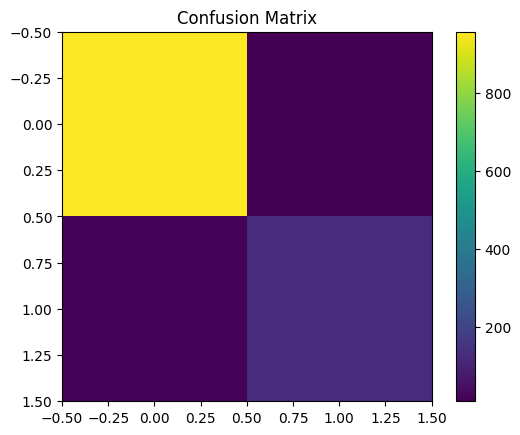

In [27]:
cm = confusion_matrix(all_labels, all_preds)
plt.imshow(cm)
plt.title("Confusion Matrix")
plt.colorbar()
plt.show()

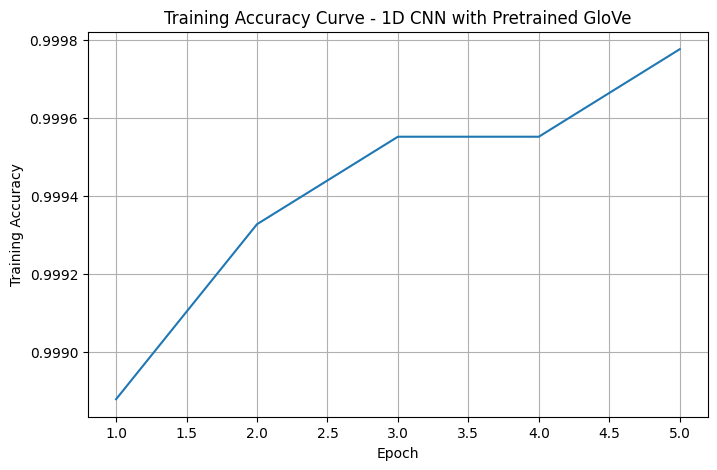

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), train_accuracies)
plt.xlabel("Epoch")
plt.ylabel("Training Accuracy")
plt.title("Training Accuracy Curve - 1D CNN with Pretrained GloVe")
plt.grid(True)
plt.show()

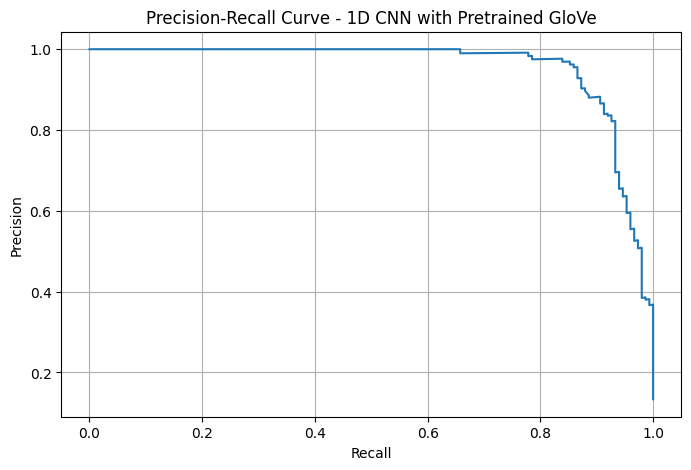

In [31]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
import torch.nn.functional as F

# Ensure model is in evaluation mode
model.eval()
all_probs = []

with torch.no_grad():
    for texts, labels in test_loader:
        texts = texts.to(device)
        outputs = model(texts)
        # Apply softmax to get probabilities and get the probability of the positive class (index 1)
        probs = F.softmax(outputs, dim=1)[:, 1]
        all_probs.extend(probs.cpu().numpy())

# Calculate precision and recall for various thresholds
precision, recall, thresholds = precision_recall_curve(y_test, np.array(all_probs))

plt.figure(figsize=(8,5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve - 1D CNN with Pretrained GloVe")
plt.grid(True)
plt.show()